In [1]:
%load_ext autoreload
%autoreload 2

# Load Packages

In [2]:
import torch
import torch.nn as nn
import torchaudio
from textless.data.speech_encoder import SpeechEncoder

# from torch_kmeans import KMeans

# Load SpeechEncoder

从textless下载并加载SpeechEncoder模型。

In [3]:
class MySpeechEncoder(nn.Module):
    def __init__(self, dense_model_name="hubert-base-ls960", quantizer_name="kmeans", vocab_size=500):
        super().__init__()
        self.model = self.load_SpeechEncoder(dense_model_name, quantizer_name=quantizer_name, vocab_size=vocab_size)

    def load_SpeechEncoder(self, dense_model_name, quantizer_name="kmeans", vocab_size=500):
        # We can build a speech encoder module using names of pre-trained
        # dense and quantizer models.  The call below will download
        # appropriate checkpoints as needed behind the scenes. We can
        # also construct an encoder by directly passing model instances
        self.encoder = SpeechEncoder.by_name(
            dense_model_name=dense_model_name,
            quantizer_model_name=quantizer_name,
            vocab_size=vocab_size,
            deduplicate=True,
            need_f0=False,
        )
        return self.encoder

    def encode_speech(self, x):
        # res is a dict with keys ('dense', 'units', 'durations').
        # It can also contain 'f0' if SpeechEncoder was initialized
        # with need_f0=True flag.
        """

        Return:
            a dict with {
                "units" : a unit id list, with no repetition
                "dense" : a tensor with shape (T, 768)
                "durations" : the duration for each unit in the `units`
                "original_units": a unit id list with length `T`
            }
        """
        res = self.model(x)

        units = res["units"]  # tensor([71, 12, 57, ...], ...)
        res["original_units"] = torch.repeat_interleave(units, res["durations"])
        return res

In [5]:
speech_encoder = MySpeechEncoder(vocab_size=100)

2024-11-24 14:37:34 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/ay/Coding2/0-Deepfake/2-Audio/models/OurModels/textless
2024-11-24 14:37:34 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': '/checkpoint/wnhsu/data/librispeech/960h/iter/250K_50hz_km100_mp0_65_v2', 'fine_tuning': False, 'labels': ['layer6.km500'], 'label_dir': None, 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2024-11-24 14:37:34 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 

# 加载数据集　

In [6]:
import sys

sys.path.insert(0, "/home/ay/zky/Coding2/0-Deepfake/2-Audio")

In [7]:
import pandas as pd
import torch
import torch.nn.functional as F
from ay2.torch.data import WaveDataset
from torch.utils.data import DataLoader, Dataset, Sampler, default_collate, random_split

In [8]:
from ay2.datasets.audio import MLAAD_AudioDs
from ay2.torchaudio.transforms.self_operation import CentralAudioClip
from tqdm import tqdm

In [9]:
def load_MLAAD_subset(root_path: str = "/home/ay/data/0-原始数据集/MLADD", language: str = "en", n_audios=1000):
    ds = MLAAD_AudioDs(root_path=root_path)
    if isinstance(language, str):
        data = ds.data.query(f"language == {language}")
    else:
        data = ds.data.query(f"language in {language}")

    sampled_data = [data.query(f"label == {i}").sample(n_audios // 2, random_state=42) for i in [0, 1]]
    sampled_data = pd.concat(sampled_data, ignore_index=True)

    _ds = WaveDataset(
        sampled_data,
        sample_rate=16000,
        normalize=True,
        transform=[CentralAudioClip(64000)],
        dtype="tensor",
    )

    _dl = DataLoader(_ds, num_workers=5, batch_size=32, shuffle=False)
    return _dl

In [10]:
dl_en = load_MLAAD_subset(language=["de"], n_audios=3000)

# 生成结果　

## help function　

In [11]:
import time

from torch import Tensor

:::{note}
在音素识别时，一个音素可能会跨多个时间帧，因此需要合并连续且相同的音素，构造为一个音素，从而预测整句话的音素，并与ground truth进行比较。
:::

那使用音素特征识别时，那么也许合并连续且相同的音素特征帧。设音素特征为`(B, T, 768)`，那么合并后的特征为`(B, T', 768)`。

In [12]:
def segment_means(x: torch.Tensor, segment_sizes: torch.Tensor) -> torch.Tensor:
    """
    Args:
      tensor: torch.Tensor: a 2D tensor with shape of `(L, C)`
      segment_sizes: torch.Tensor: a 1D tensor that its sum is equal to the length `L` of tensor

    Returns:
        torch.Tenosr: the tensor with reduce length `(L', C)`, where $L'=len(segment_sizes)$
    """
    assert x.size(0) == segment_sizes.sum(), "Sum of segment sizes must equal the tensor's first dimension size."

    # Create an indices tensor that maps each row in the tensor to its corresponding segment
    indices = torch.repeat_interleave(torch.arange(len(segment_sizes), device=x.device), segment_sizes)

    # Create a tensor to hold the sum of each segment
    segment_sums = torch.zeros(len(segment_sizes), x.size(1), device=x.device)

    # Scatter and sum the inputs into the segment_sums tensor
    segment_sums.scatter_add_(0, indices.unsqueeze(1).expand(-1, x.size(1)), x)

    # Calculate the mean of each segment
    segment_means = segment_sums / segment_sizes.unsqueeze(1)

    return segment_means

In [13]:
## 验证
x = torch.randn(5, 1)
segments = torch.tensor([1, 2, 2])
res = segment_means(x, segments)
print(x, "\n", res)

tensor([[ 0.0162],
        [ 0.5102],
        [ 1.0662],
        [-0.0107],
        [ 0.9693]]) 
 tensor([[0.0162],
        [0.7882],
        [0.4793]])


In [14]:
def reduce_feat_by_phonemes(
    hidden_states: Tensor, audio_lengths: Tensor, phoneme_ids: Tensor, debug: bool = False
) -> Tensor:
    """
    For each audio, combine continuous phonemes to reduce the temporal dimension of audio features.
    For example, the audio with 10 frames, which phoneme ids will change from
    ```python
    [0, 0, 0, 1, 1, 1, 2, 2, 0, 0] -> [0, 1, 2, 0]
    ```
    and the hidden_states will also changed by this way.


    Args:
      hidden_states:Tensor: a 3D tensor with shape of (B, T, C), where T is audio frames
      audio_lengths:Tensor: a 1D tensor with shape of (B,) that represent the legnth of each audio
      phoneme_ids:Tensor: a 2D tensor with shape of (B, T) that represents the phoneme ids in each audio frame
      debug:bool: determine whether to debug tensor info.

    Returns:
        the reduced hidden_states with shape (B*L', C), reduced audio lengths, reduced phoneme ids.
    """

    reduced_hidden_states = []
    reduced_audio_lengths = []
    reduced_phoneme_ids = []
    phoneme_counts = []

    if debug:
        s = time.time()
        print("reduce feat input:", hidden_states.shape, audio_lengths.shape, phoneme_ids.shape)

    for i in range(len(audio_lengths)):
        _phoneme_ids = phoneme_ids[i, : audio_lengths[i]]
        unique_ids, _phoneme_counts = _phoneme_ids.unique_consecutive(return_counts=True)
        phoneme_counts += _phoneme_counts.tolist()

        reduced_audio_lengths.append(len(unique_ids))
        reduced_phoneme_ids.append(unique_ids)

    reduced_audio_lengths = torch.tensor(reduced_audio_lengths)
    reduced_phoneme_ids = torch.nn.utils.rnn.pad_sequence(reduced_phoneme_ids, batch_first=True)
    h = torch.concat([hidden_states[i, :_len, :] for i, _len in enumerate(audio_lengths)], dim=0)
    reduced_hidden_states = segment_means(h, torch.tensor(phoneme_counts, device=hidden_states.device))

    if debug:
        e = time.time()
        print(
            "reduce feat output:", reduced_hidden_states.shape, reduced_audio_lengths.shape, reduced_phoneme_ids.shape
        )
        print("reduce feat time:", e - s)
    return reduced_hidden_states, reduced_audio_lengths, reduced_phoneme_ids

In [21]:
reduced_hidden_states, reduced_audio_lengths, reduced_phoneme_ids = reduce_feat_by_phonemes(
    hidden_states=torch.tensor(dense_res),
    audio_lengths=torch.tensor([149] * len(dense_res)),
    phoneme_ids=torch.tensor(full_unit_res),
    debug=1,
)

split_res = torch.split(reduced_hidden_states, tuple(reduced_audio_lengths.numpy()))

id_based_frame_res = torch.stack([x.mean(0) for x in split_res]).numpy()

reduce feat input: torch.Size([3000, 199, 768]) torch.Size([3000]) torch.Size([3000, 199])
reduce feat output: torch.Size([259433, 768]) torch.Size([3000]) torch.Size([3000, 122])
reduce feat time: 0.5426139831542969


## Load data and Collect res　

In [16]:
speech_encoder = speech_encoder.to("cuda:1")

In [17]:
dense_res = []
frame_res = []
unit_res = []
full_unit_res = []

for batch in tqdm(dl_en):
    for x in batch["audio"]:  ### torch.Size([1, 48000])
        with torch.no_grad():
            res = speech_encoder.encode_speech(x=x.cuda(1))
            dense_res.append(res["dense"])
            frame_res.append(res["dense"].mean(0))
            unit_res.append(res["units"])
            full_unit_res.append(res["original_units"])

dense_res = torch.stack(dense_res).cpu().numpy()
frame_res = torch.stack(frame_res).cpu().numpy()
full_unit_res = torch.stack(full_unit_res).cpu().numpy()
unit_res = torch.nn.utils.rnn.pad_sequence(unit_res, batch_first=True).cpu().numpy()

vocoder_labels = list(dl_en.dataset.data["vocoder_label"])
labels = list(dl_en.dataset.data["label"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:29<00:00,  3.23it/s]


# 可视化　

In [19]:
from ay2.visualization._scatter import plot_cluster_res
from ay2.visualization.tsne import plot_tSNE_res, tSNE_cluster
from ay2.visualization._utils import calculate_clustering_scores

In [22]:
calculate_clustering_scores(id_based_frame_res, n_clusters=2, labels=labels)
calculate_clustering_scores(frame_res, n_clusters=2, labels=labels)
calculate_clustering_scores(unit_res, n_clusters=2, labels=labels)
calculate_clustering_scores(full_unit_res, n_clusters=2, labels=labels)

Silhouette Score: 0.05349663272500038 Davies-Bouldin Index: 4.391655048151248 Calinski-Harabasz Index: 143.91259236289136
Silhouette Score: 0.17390312254428864 Davies-Bouldin Index: 2.285116856877186 Calinski-Harabasz Index: 375.336199657712
Silhouette Score: 0.05791655087846614 Davies-Bouldin Index: 3.6973769118223863 Calinski-Harabasz Index: 207.54445073320068
Silhouette Score: 0.010456286043145066 Davies-Bouldin Index: 8.886378368591558 Calinski-Harabasz Index: 36.291996938607326


(0.010456286043145066, 8.886378368591558, 36.291996938607326)

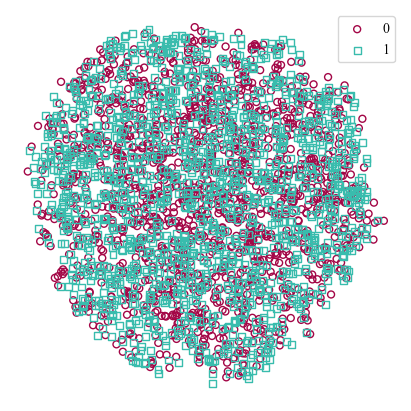

Silhouette Score: 0.3460955321788788 Davies-Bouldin Index: 1.178546378337072 Calinski-Harabasz Index: 1809.388364906517


In [23]:
plot_cluster_res(
    dense_res.mean(-1),
    labels=labels,
    cluster_method="umap",
    legend_labels=[0, 1],
    print_cluster_score=True,
)

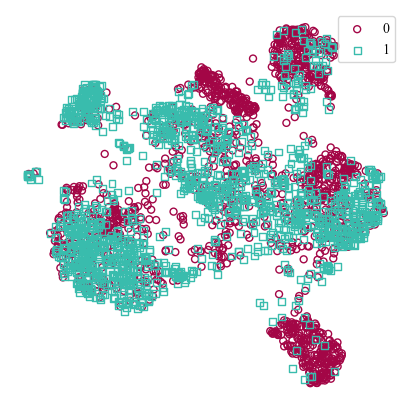

Silhouette Score: 0.40504708886146545 Davies-Bouldin Index: 0.985180680100823 Calinski-Harabasz Index: 2259.8619874748124


In [24]:
plot_cluster_res(
    id_based_frame_res,
    labels=labels,
    cluster_method="umap",
    legend_labels=[0, 1],
    print_cluster_score=True,
)

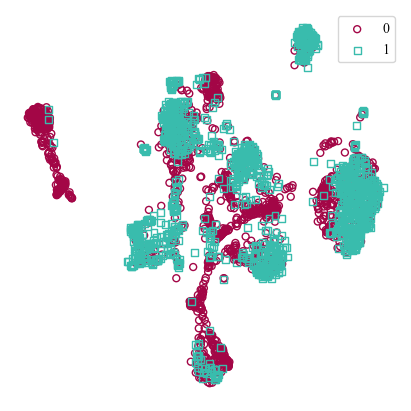

Silhouette Score: 0.41135677695274353 Davies-Bouldin Index: 0.942412737585389 Calinski-Harabasz Index: 2594.7646391462094


In [25]:
plot_cluster_res(
    frame_res,
    labels=labels,
    cluster_method="umap",
    legend_labels=[0, 1],
    print_cluster_score=True,
)

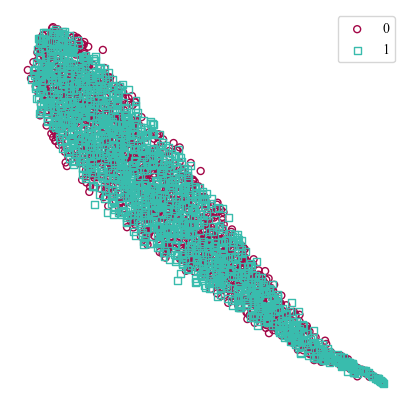

Silhouette Score: 0.5682573914527893 Davies-Bouldin Index: 0.5890648562942844 Calinski-Harabasz Index: 6603.088764868842


In [26]:
plot_cluster_res(
    unit_res,
    labels=labels,
    cluster_method="umap",
    legend_labels=[0, 1],
    print_cluster_score=True,
)

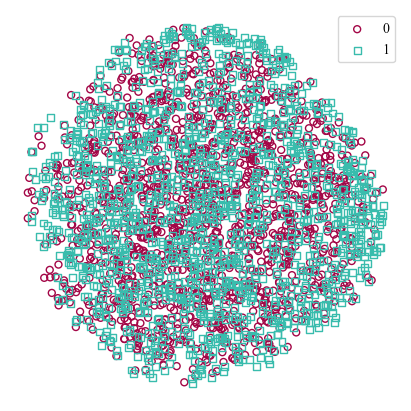

Silhouette Score: 0.3395531177520752 Davies-Bouldin Index: 1.2020247865054376 Calinski-Harabasz Index: 1724.5534607043085


In [27]:
plot_cluster_res(
    full_unit_res,
    labels=labels,
    cluster_method="umap",
    legend_labels=[0, 1],
    print_cluster_score=True,
)